## Week - 8 - Deep Neural Nets and Text - Training Models

In this week we will be introduced to using Deep Neural Networks to work with text. We have already seen some uses of neural networks for text in our classification HW, where we used a simple neural network to classify text - it performs quite well, but they can come up short in more sophisticated classification tasks, such as in predicting intent. We have also seen neural nets in the form of word embeddings such as Word2Vec - and while they certainly work well, they have some drawbacks, such as dealing with words with multiple meanings. 

BERT, which is a language model built using bidirectional encoders, allows us to have a powerful pre-trained model which we can then use to perform our own tasks based on the data we are analysing. 

In this notebook we will use ```huggingface/transformers```, which is a python package which allows for an easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, though to reach state-of-the-art results we will stick with using BERT and similar models.

To demonstrate this, we will use the [Corpus of Linguistic Acceptability](https://nyu-mll.github.io/CoLA/). We will also be using BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences.
There are a bunch of new packages and methods we will be using so be sure to update lucem_illud_2020.

Note that this notebook is different to take advantage of the GPU here. We only run the GPU heavy tasks here, where we need models to be fine-tuned.

The first section contains the CoLA classification task, the second contains training a model on Trump tweets, and the last bit has us training a model on US and UK blog posts.

To switch on your GPU, go to edit -> notebook settings -> hardware accelerator -> enable GPU.


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

     |████████████████████████████████| 1.9MB 17.5MB/s 
     |████████████████████████████████| 3.2MB 49.5MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c986784a4444d05a67993301bf0b3a6390b55bd6d4f371da1f3262fce3232469
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

In [7]:
review_raw = pd.read_csv("e-commerce_reviews.csv")
review_raw.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
# Extract data for analysis
review = review_raw[['Review Text','Rating','Class Name','Age']]
review.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [10]:
review['Review Text'] = review['Review Text'].fillna('') #Fill NA values by space
#Create a label based on ratings: 1 for 4 and higher, 0 for 2 and lower.
review_df = review[review['Rating'] != 3]
review_df['label'] = np.where(review_df['Rating']>=4, 1, 0) 
review_df.head()

,Review Text,Rating,Class Name,Age,label
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,1
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,1
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,1
4,This shirt is very flattering to all due to th...,5,Blouses,47,1
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,0


In [11]:
# Training model with 80% of the data and 20% for testing
train_df = review_df[:int(review_df.shape[0]*0.8)]

In [12]:
# Create sentence and label lists
sentences = train_df['Review Text'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_df.label.values

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable', '[SEP]']


In [14]:
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [15]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [16]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [17]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [18]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Deep Neural Nets

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [20]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [21]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976704    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [22]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
464/464 [==============================] - 40s 17ms/step - loss: 0.3992 - accuracy: 0.8731
Epoch 2/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3645 - accuracy: 0.8805
Epoch 3/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3477 - accuracy: 0.8831
Epoch 4/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3586 - accuracy: 0.8843
Epoch 5/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3510 - accuracy: 0.8859
Epoch 6/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3524 - accuracy: 0.8835
Epoch 7/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3511 - accuracy: 0.8858
Epoch 8/10
464/464 [==============================] - 8s 17ms/step - loss: 0.3074 - accuracy: 0.8803
Epoch 9/10
464/464 [==============================] - 8s 17ms/step - loss: 0.2558 - accuracy: 0.9105
Epoch 10/10
464/464 [==============================] - 8s 17ms/step - loss: 0.2145 - accur

From the above results, we can see that the accuracy of this model performs well, it hovers around 94%. Then we can implement BERT to see the performance.

### On with BERT!

In [23]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [24]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [28]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    464.    Elapsed: 0:00:29.
  Batch    80  of    464.    Elapsed: 0:00:57.
  Batch   120  of    464.    Elapsed: 0:01:25.
  Batch   160  of    464.    Elapsed: 0:01:53.
  Batch   200  of    464.    Elapsed: 0:02:22.
  Batch   240  of    464.    Elapsed: 0:02:50.
  Batch   280  of    464.    Elapsed: 0:03:18.
  Batch   320  of    464.    Elapsed: 0:03:46.
  Batch   360  of    464.    Elapsed: 0:04:14.
  Batch   400  of    464.    Elapsed: 0:04:42.
  Batch   440  of    464.    Elapsed: 0:05:10.

  Average training loss: 0.17
  Training epcoh took: 0:05:27

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:13

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    464.    Elapsed: 0:00:28.
  Batch    80  of    464.    Elapsed: 0:00:56.
  Batch   120  of    464.    Elapsed: 0:01:24.
  Batch   160  of    464.    Elapsed: 0:01:52.
  Batch   200  of    464.    Elapsed: 0:02:20.
  Batch   240  of    464.    Elap

### Training Evaluation

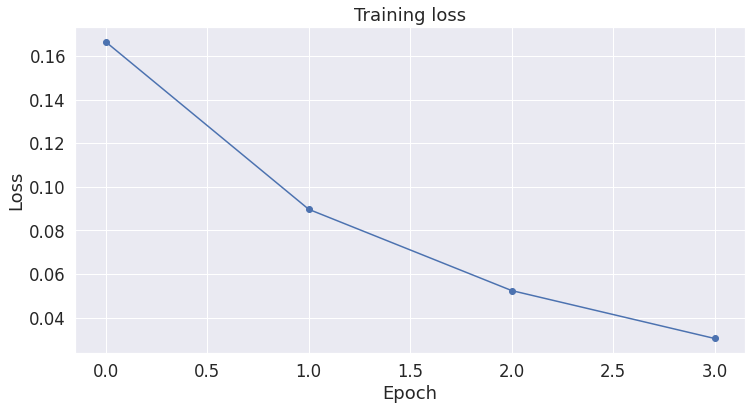

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

The BERT model performs the same as LSTM, with an accuracy rate at 96%. From the graph above, we can see that as epoch number increases, average training loss decreases.

### Holdout Set

In [34]:
test_df = review_df[int(review_df.shape[0]*0.8):]
test_df.head()

,Review Text,Rating,Class Name,Age,label
18811,Really like the cut - it's tough for petites t...,5,Pants,35,1
18812,Absolutely love this sweater! it is a tad bit ...,5,Knits,35,1
18813,"This top is very nice, very pretty. i thought ...",4,Blouses,26,1
18814,"I like the color blocking of this top, but it ...",2,Knits,37,0
18815,"I love these! i adore tracy reese, and these a...",5,Pants,38,1


In [36]:
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df['Review Text'].values
labels = test_df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,123



In [37]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,123 test sentences...
    DONE.


In [38]:
print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))

Positive samples: 3644 of 4123 (88.38%)


In [40]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [41]:
matthews_set

[0.7948717948717948,
 0.6831300510639733,
 1.0,
 0.8027729719194864,
 0.0,
 1.0,
 0.8027729719194864,
 0.7141684885491869,
 0.6753002216523571,
 0.6050580452280905,
 0.8509629433967631,
 1.0,
 0.6050580452280905,
 1.0,
 0.7867957924694432,
 0.7474093186836597,
 1.0,
 0.8027729719194864,
 0.8509629433967631,
 0.6180700462007377,
 0.8783100656536799,
 0.8027729719194864,
 0.8132500607904443,
 0.6180700462007377,
 0.8783100656536799,
 1.0,
 0.762962962962963,
 1.0,
 1.0,
 0.7867957924694432,
 0.6180700462007377,
 -0.03225806451612903,
 0.7474093186836597,
 0.52678658400752,
 0.6180700462007377,
 0.7948717948717948,
 1.0,
 0.7419408268023742,
 1.0,
 1.0,
 0.8958064164776167,
 1.0,
 0.0,
 0.38461538461538464,
 0.4547940268270977,
 0.8132500607904443,
 0.9278305692406299,
 0.8171428571428572,
 0.762962962962963,
 0.8783100656536799,
 0.6050580452280905,
 0.8783100656536799,
 0.0,
 0.5584155773160767,
 0.0,
 0.8958064164776167,
 0.6956083436402525,
 1.0,
 0.6831300510639733,
 0.87831006565367

In [42]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.785


In [43]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

From the result above, we can see the model performed well with our dataset.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

### Segment ID

In [44]:
review_df.head()

,Review Text,Rating,Class Name,Age,label
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,1
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,1
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,1
4,This shirt is very flattering to all due to th...,5,Blouses,47,1
5,"I love tracy reese dresses, but this one is no...",2,Dresses,49,0


In [45]:
text = review_df['Review Text'][0]
text

'Absolutely wonderful - silky and sexy and comfortable'

In [46]:
from transformers import BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
print (tokenized_text)

['[CLS]', 'absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable', '[SEP]']


In [51]:
# see the vocabulary looks like
list(tokenizer.vocab.keys())[5000:5030]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes',
 'equal',
 'comic',
 'patients',
 'hidden',
 'solid',
 'actual',
 'bringing',
 'afternoon',
 'touched',
 'funds']

In [52]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

In [53]:
# Segment id
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [55]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [56]:
output = model_embedding(tokens_tensor, segments_tensors)
len(output[0][0][0]), len(output[1][0])

(768, 768)

### Understanding Output

In [61]:
word_embeddings = output[0]
sentence_embedding = output[1]

In [62]:
len(word_embeddings[0])

10

In [63]:
word_embeddings[0]

tensor([[-0.4399, -0.0191, -0.0617,  ..., -0.3785,  0.1435,  0.4821],
        [ 0.6304,  0.1536,  0.2274,  ..., -0.3958,  0.9708,  0.6290],
        [ 0.6038,  0.5120,  0.3658,  ..., -0.7298,  0.4188, -0.3061],
        ...,
        [-0.9268, -0.4823,  0.4026,  ..., -0.2851,  0.4595,  0.5096],
        [-0.7741, -0.5284,  0.2177,  ..., -0.5207,  0.3757, -0.3708],
        [ 0.7537,  0.0132, -0.3186,  ..., -0.1667, -0.6352, -0.1745]],
       grad_fn=<SelectBackward>)

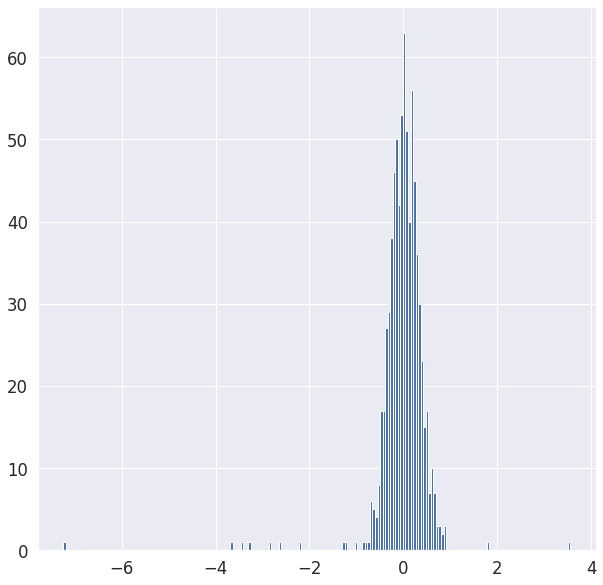

In [64]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

The range is fairly similar for all layers and tokens, with the majority of values falling between [-1, 1].

### Word Vector

In [65]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [66]:
len(token_vecs)

10

### Sentence Vector

In [67]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]
sentence_embedding_1 = np.mean(token_vecs, axis=0)
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

In [69]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 absolutely
2 wonderful
3 -
4 silky
5 and
6 sexy
7 and
8 comfortable
9 [SEP]


In [70]:
from scipy.spatial.distance import cosine
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.031909238547086716

In [76]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    output = model(tokens_tensor)
    word_embeddings = output[0]
    sentence_embeddings = output[1]   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [77]:
word_4 = word_vector(text, 4, model_embedding, tokenizer)
word_5 = word_vector(text, 5, model_embedding, tokenizer)
word_6 = word_vector(text, 6, model_embedding, tokenizer)

In [80]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    output = model(tokens_tensor)
    word_embeddings = output[0]
    sentence_embeddings = output[1]
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [81]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

In [83]:
(len(sen_vec_0), len(sen_vec_1))

(768, 1)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [87]:
twitter_df = pd.read_csv("trump_twitter.csv")
twitter_df.head()

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [88]:
# Keep the first 5000 tweets for simplicity
twitter_df = twitter_df[:5000]

In [92]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(twitter_df['content'], test_size=0.2)
train_text.head()

3100    OPEC is better off than they were 4 years ago....
389     I appreciate the kind words of Mike Huckabee, ...
4672    Pres. Obama’s steady support of @ Israel throu...
133     and yet another ...all of them are spectacular...
1100    I know that Diane Brady is a great writer--she...
Name: content, dtype: object

In [93]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [94]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

In [95]:
torch.cuda.empty_cache()

In [97]:
!python /content/run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=/content/train_text_trump --do_eval --eval_data_file=/content/test_text_trump --per_gpu_train_batch_size=1 --per_gpu_eval_batch_size=1

03/08/2021 21:07:47 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/08/2021 21:07:47 - INFO - filelock -   Lock 140243839812624 acquired on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
Downloading: 100% 665/665 [00:00<00:00, 1.06MB/s]
03/08/2021 21:07:47 - INFO - filelock -   Lock 140243839812624 released on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
03/08/2021 21:07:47 - INFO - filelock -   Lock 140243714811856 acquired on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f.lock
Downloading: 100% 1.04M/1.04M [00:00<00:00, 25.2MB/s]
03/08/2021 2

In [98]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/output_gpt_trump

03/08/2021 21:09:46 - INFO - __main__ -   Namespace(device=device(type='cuda'), k=0, length=20, model_name_or_path='/content/output_gpt_trump', model_type='gpt2', n_gpu=1, no_cuda=False, num_return_sequences=1, p=0.9, padding_text='', prompt='', repetition_penalty=1.0, seed=42, stop_token=None, temperature=1.0, xlm_language='')
Model prompt >>> gpt2
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
=== GENERATED SEQUENCE 1 ===
2021-03-08 21:11:35.498843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
gpt2k."
""Tomorrow night, @telemusicetta will return to Florida at 9


In [99]:
from transformers import AutoModelWithLMHead, AutoTokenizer
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [100]:
sequence = "president election is"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

president election is a disaster for the country."
"The US is a laughing stock in the world of politics. The US is a laughing stock in the world of politics. The US is a laughing stock in the world of politics."
"The


In [101]:
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [104]:
sequence = "president election is"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

president election is a very important moment for the country," he said.

"We have to be very careful about what we say and what we say in the media. We have to be very careful about what we say and what we say in


The models generated the opposite results based on the same sequence. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In [105]:
review.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [106]:
# rating = 3 neutral
# rating >= 4 postive
# rating <= 2 negative
neutral_df = review[review['Rating']==3]
positive_df = review[review['Rating']>=4]
negative_df = review[review['Rating']<=2]

In [107]:
train_text1, test_text1 = train_test_split(neutral_df['Review Text'], test_size=0.2)
train_text2, test_text2 = train_test_split(positive_df['Review Text'], test_size=0.2)
train_text3, test_text3 = train_test_split(negative_df['Review Text'], test_size=0.2)
train_text1.to_frame().to_csv(r'train_text_rev1', header=None, index=None, sep=' ', mode='a')
test_text1.to_frame().to_csv(r'test_text_rev1', header=None, index=None, sep=' ', mode='a')
train_text2.to_frame().to_csv(r'train_text_rev2', header=None, index=None, sep=' ', mode='a')
test_text2.to_frame().to_csv(r'test_text_rev2', header=None, index=None, sep=' ', mode='a')
train_text3.to_frame().to_csv(r'train_text_rev3', header=None, index=None, sep=' ', mode='a')
test_text3.to_frame().to_csv(r'test_text_rev3', header=None, index=None, sep=' ', mode='a')

In [108]:
# Fine tune these three set of reviews
!python run_language_modelling.py --output_dir=output_roberta_rev1 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev1 --do_eval --eval_data_file=test_text_rev1 --mlm --overwrite_output_dir
!python run_language_modelling.py --output_dir=output_roberta_rev2 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev2 --do_eval --eval_data_file=test_text_rev2 --mlm --overwrite_output_dir
!python run_language_modelling.py --output_dir=output_roberta_rev3 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_text_rev3 --do_eval --eval_data_file=test_text_rev3 --mlm  --overwrite_output_dir

03/08/2021 21:18:52 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/08/2021 21:18:52 - INFO - filelock -   Lock 140664201012368 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
Downloading: 100% 481/481 [00:00<00:00, 764kB/s]
03/08/2021 21:18:52 - INFO - filelock -   Lock 140664201012368 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
03/08/2021 21:18:52 - INFO - filelock -   Lock 140664201012432 acquired on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
Downloading: 100% 899k/899k [00:00<00:00, 24.5MB/s]
03/08/2021 21:1

In [110]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

roberta_1_model_embedding = RobertaModel.from_pretrained('output_roberta_rev1')
roberta_1_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev1')
roberta_2_model_embedding = RobertaModel.from_pretrained('output_roberta_rev2')
roberta_2_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev2')
roberta_3_model_embedding = RobertaModel.from_pretrained('output_roberta_rev3')
roberta_3_tokenizer = RobertaTokenizer.from_pretrained('output_roberta_rev3')

Some weights of RobertaModel were not initialized from the model checkpoint at output_roberta_rev1 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at output_roberta_rev2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at output_roberta_rev3 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


amazing beautiful high great recommend
 
For neutral reviews: 


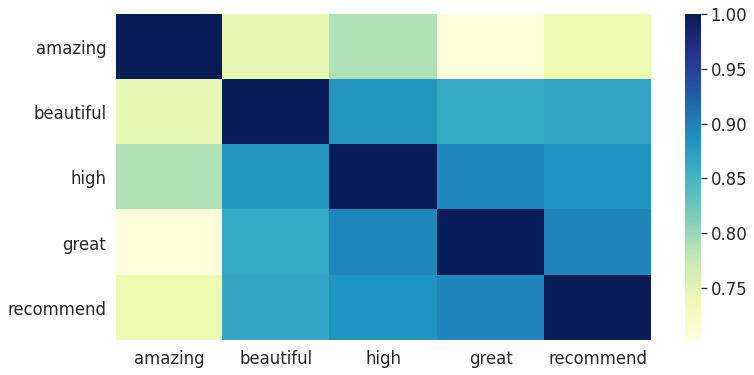

For postive reviews: 


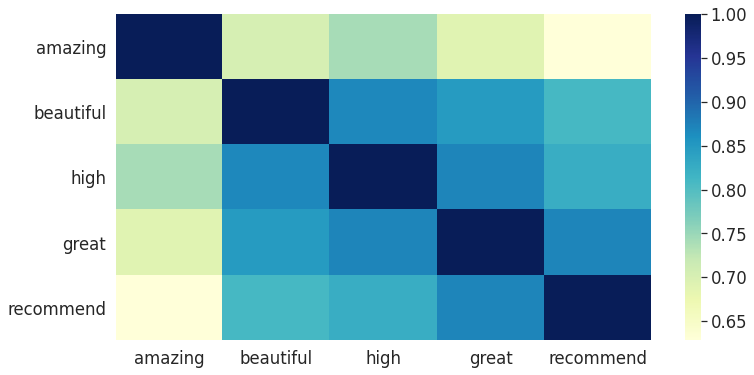

For negative reviews: 


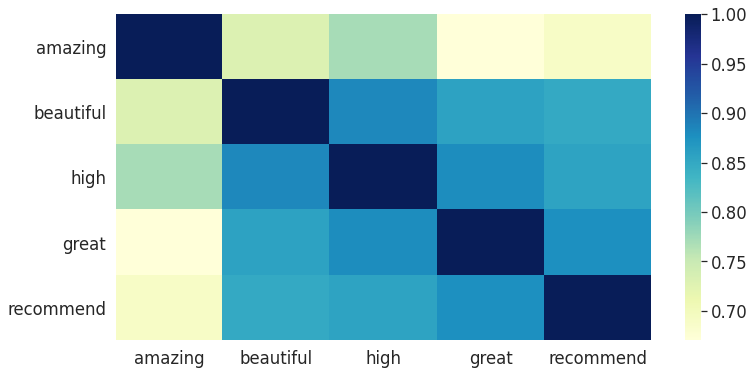

In [115]:
text = "amazing beautiful high great recommend"
print("amazing beautiful high great recommend")
import seaborn as sns
from scipy.spatial.distance import cosine

def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    output = model(tokens_tensor)
    word_embeddings, sentence_embeddings = output[0], output[1]   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div, cmap="YlGnBu")
    plt.show()

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)

ugly uncomfortable worst poor avoid
 
For neutral reviews: 


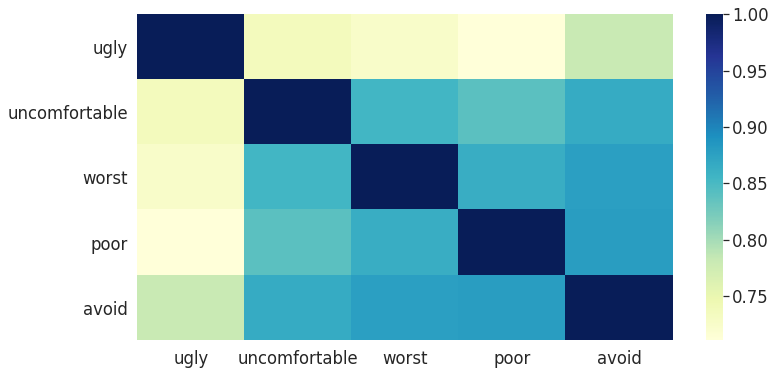

For postive reviews: 


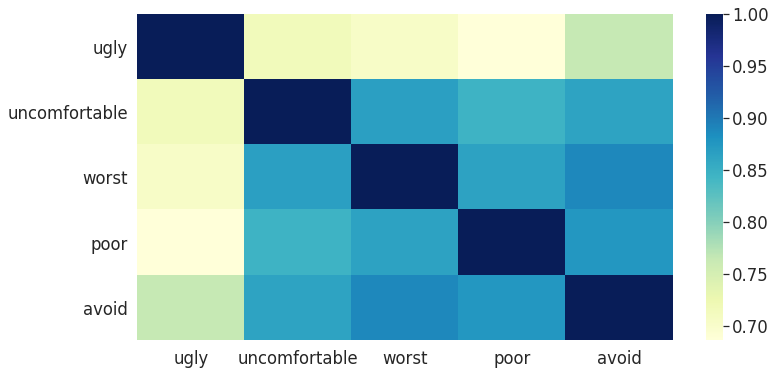

For negative reviews: 


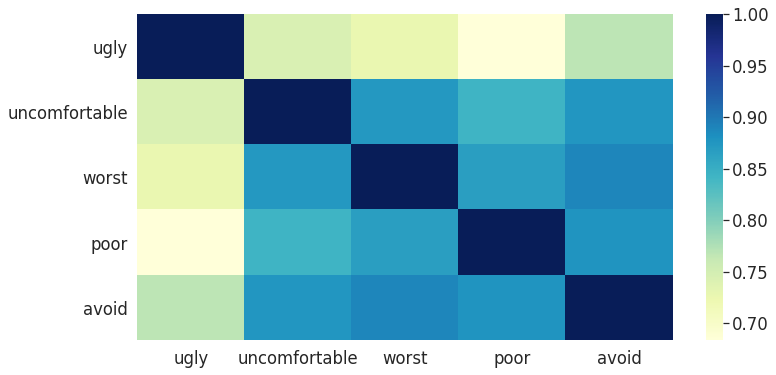

In [116]:
text = "ugly uncomfortable worst poor avoid"
print("ugly uncomfortable worst poor avoid")

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)

ok plain common usual general ecumenical
 
For neutral reviews: 


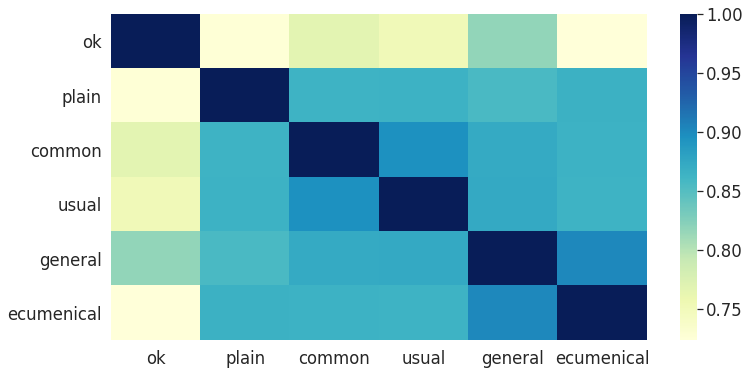

For postive reviews: 


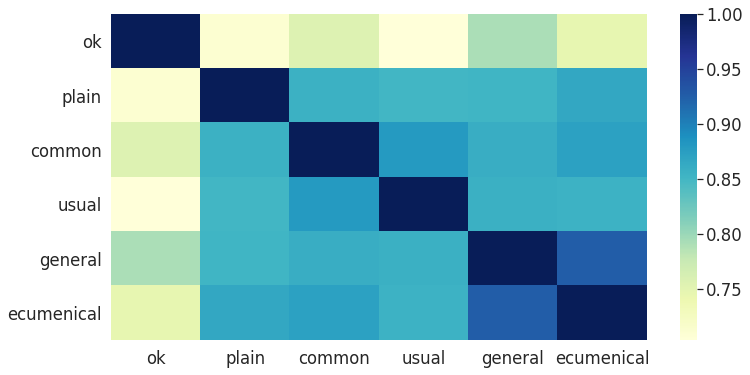

For negative reviews: 


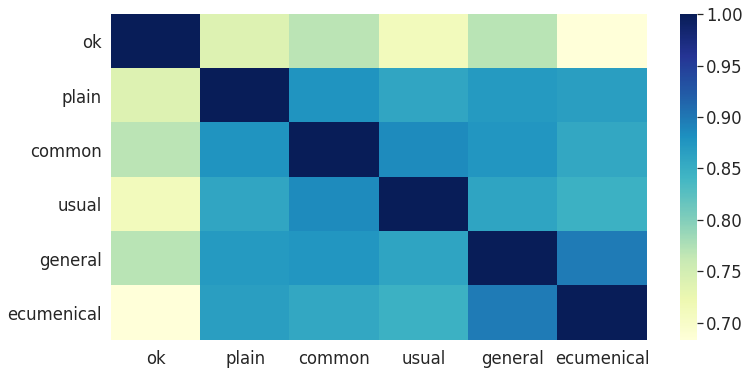

In [117]:
text = "ok plain common usual general ecumenical"
print("ok plain common usual general ecumenical")

print(" ")
print("For neutral reviews: ")
visualise_diffs(text, roberta_1_model_embedding, roberta_1_tokenizer)
print("For postive reviews: ")
visualise_diffs(text, roberta_2_model_embedding, roberta_2_tokenizer)
print("For negative reviews: ")
visualise_diffs(text, roberta_3_model_embedding, roberta_3_tokenizer)

The three models are respectively trained from reviews that received neutral (=3), positive (>=4), and negative (<=2) ratings. According to the heatmaps generated, we cannot tell the differences between the similarities between these keywords in the all three dataset. In addition, the similarities between keywords are relatively high - the similarity rate being around 0.8. This suggests that these words occur frequently in reviews with all ratings and the model cannot distinguish between these words trained from different datasets. 